# 텐서로 변환

+ 지금까진 입력값이 scalar값임.
+ 모든 머신러닝은 텐서가 기본임.
+ 따라서 dezero를 텐서 처리를 할 수 있도록 해야함

기존 스칼라값 처리

In [2]:
import numpy as np
import dezero.functions as F
from dezero import Variable

x = Variable(np.array(1.1))
y = F.sin(x)
y.backward()

print(y.data)
print(x.grad)

0.8912073600614354
variable(0.4535961214255773)


텐서 처리

In [3]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sin(x)
y.backward()

print(y.data)
print(x.grad)

[[ 0.84147098  0.90929743  0.14112001]
 [-0.7568025  -0.95892427 -0.2794155 ]]
variable([[ 0.54030231 -0.41614684 -0.9899925 ]
          [-0.65364362  0.28366219  0.96017029]])


In [4]:
y.cleargrad()
c = Variable(np.array([10, 20, 30]))
y = x + c
y.backward()

print(y.data)
print(x.grad)

[[11 22 33]
 [14 25 36]]
variable([[1.54030231 0.58385316 0.0100075 ]
          [0.34635638 1.28366219 1.96017029]])


input값이 tensor고 출력값이 scalar인 경우

In [5]:
x = Variable(np.array([[2, 3, 4], [4, 5, 6]]))
c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
t = 2 * x + c
y = F.sum(t)
y.backward(retain_grad=True)

print(y.data)
print(t.grad)
print(x.grad)
print(c.grad)

258
variable([[1 1 1]
          [1 1 1]])
variable([[2 2 2]
          [2 2 2]])
variable([[1 1 1]
          [1 1 1]])


순전파의 형태와 역전파의 형태가 일치해야한다.

즉 y.grad.shape == y.shape / x.grad.shape == x.shape

y.backward(retain_grad=True)하는 이유?? -> t.grad를 확인하기 위해서

In [6]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
t = x + c
y = F.sum(t)
y.backward()

print(y.data)
print(t.grad)

231
None


retain_grad를 안하면 중간과정의 미분값을 제거하기 때문에 None이 나와 shape 확인 불가능

# 형상 변환

+ tensor가 입력값이기 때문에 shape을 변환할 일이 생김
+ tensor처리를 위해 reshape, transpose함수 구현
+ 형상 변환을 통해 순전파시 shape이 변경되었다면 역전파시 shape을 다시 동일하게 복원해야함

## reshape

In [7]:
x = np.array([[1, 2, 3], [4, 5, 6]])
y = x.reshape((6,))

print(x.shape)
print(x)
print()
print(y.shape)
print(y)

(2, 3)
[[1 2 3]
 [4 5 6]]

(6,)
[1 2 3 4 5 6]


In [8]:
from dezero.core import Function

# (2, 3) -> (6,) 이라면 backward에서는 (6,) -> (2, 3)으로 바꿔줘야 한다.
class Reshape(Function):
    def __init__(self, shape):
        self.shape = shape
        
    def forward(self, x):
        self.x_shape = x.shape
        y = x.reshape(self.shape)
        return y

    def backward(self, gy):
        return reshape(gy, self.x_shape)
    
from dezero.core import as_variable

def reshape(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return Reshape(shape)(x)

In [9]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = Reshape((6, ))(x)
y.backward()

print(x.data.shape)
print(x.data)
print()
print(y.data.shape)
print(y.data)
print()
print(x.grad.shape)
print(x.grad)

(2, 3)
[[1 2 3]
 [4 5 6]]

(6,)
[1 2 3 4 5 6]

(2, 3)
variable([[1 1 1]
          [1 1 1]])


In [10]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = x.reshape((6,))
y.backward()

print(x.data.shape)
print(x.data)
print()
print(y.data.shape)
print(y.data)
print()
print(x.grad.shape)
print(x.grad)

(2, 3)
[[1 2 3]
 [4 5 6]]

(6,)
[1 2 3 4 5 6]

(2, 3)
variable([[1 1 1]
          [1 1 1]])


작성한 코드가 동일하게 작동하는 모습

## transpose

In [11]:
x = np.array([[1, 2, 3], [4, 5, 6]])
# y = x.transpose()
y = x.T
print(x.shape)
print(x)
print()
print(y.shape)
print(y)

(2, 3)
[[1 2 3]
 [4 5 6]]

(3, 2)
[[1 4]
 [2 5]
 [3 6]]


In [12]:
class Transpose(Function):
    def forward(self, x):
        y = np.transpose(x)
        return y

    def backward(self, gy):
        gx = transpose(gy)
        return gx
    
def transpose(x):
    return Transpose()(x)

In [13]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = transpose(x)
y.backward()

print(x.data.shape)
print(x.data)
print()
print(y.data.shape)
print(y.data)
print()
print(x.grad.shape)
print(x.grad)

(2, 3)
[[1 2 3]
 [4 5 6]]

(3, 2)
[[1 4]
 [2 5]
 [3 6]]

(2, 3)
variable([[1 1 1]
          [1 1 1]])


variable class에 property로 T 구현했기 때문에 x.T도 가능함

In [14]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = x.T
y.backward()

print(x.data.shape)
print(x.data)
print()
print(y.data.shape)
print(y.data)

(2, 3)
[[1 2 3]
 [4 5 6]]

(3, 2)
[[1 4]
 [2 5]
 [3 6]]


# sum 함수

+ input shape을 기억했다가 역전파시 output shape을 기억했던 shape으로 변경해주고 output을 넘겨줘야한다.

```python
class Sum(Function):
    def forward(self, x):
        self.x_shape = x.shape
        y = x.sum()
        return y

    def backward(self, gy):
        gx = broadcast_to(gy, self.x_shape)
        return gx

def sum(x):
    return Sum()(x)
```

In [15]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sum(x)
y.backward()

print(y.data)
print(x.grad)

21
variable([[1 1 1]
          [1 1 1]])


## axis, keepdims 테스트
+ axis는 축을 지정하는 인자로 axis=0일땐 열방향(y축, 세로 방향)으로 계산, axis=1일땐 행방향(x축, 가로 방향)으로 계산
+ keepdims는 축의 수를 유지하는 인자로 true시 2차원이면 2차원으로 output되고 false면 scalar값으로 output된다.

In [16]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sum(x, axis=0)
y.backward()

print(y.data)
print(x.grad)

[5 7 9]
variable([[1 1 1]
          [1 1 1]])


In [17]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sum(x, axis=1)
y.backward()

print(y.data)
print(x.grad)

[ 6 15]
variable([[1 1 1]
          [1 1 1]])


In [18]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = x.sum(keepdims=True)
y.backward()

print(y.data)
print(x.grad)

[[21]]
variable([[1 1 1]
          [1 1 1]])


In [19]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]).reshape(1, 2, 3))
y = x.sum(keepdims=True)
y.backward()

print(y.data)
print(y.data.shape)
print(x.grad.shape)
print(x.grad)

[[[21]]]
(1, 1, 1)
(1, 2, 3)
variable([[[1 1 1]
           [1 1 1]]])


# 추가적인 형상 변환 함수

+ broadcast_to함수는 차원늘 늘려서 shape을 변경한다.
+ sum_to함수는 합쳐서 차원을 줄이는 함수이다.

두 함수는 모두 형상이 맞지 않는 값끼리 계산을 해야할 때 사용된다.

In [20]:
x = np.array([[1, 2, 3], [4, 5, 6]])
np.broadcast_to(x, (3, 2, 3))

array([[[1, 2, 3],
        [4, 5, 6]],

       [[1, 2, 3],
        [4, 5, 6]],

       [[1, 2, 3],
        [4, 5, 6]]])

In [21]:
from dezero.utils import sum_to

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
print(sum_to(x, (1, 3)))
print(sum_to(x, (2, 1)))

variable([[5 7 9]])
variable([[ 6]
          [15]])


broadcast_to 역전파시에는 sum_to를 사용하여 차원을 줄이고,

sum_to 역전파시에는 broadcast_to를 이용하여 차원을 늘린다.

왜 sum_to 역전파시에는 차원이 늘면서 전달되는 미분값은 변하지 않는데 broadcast_to 역전파시에는 sum_to를 사용하여 차원이 줄면서 역전파 값이 변하는가?

-> boardcast_to 사용하면 tensor를 복제하여 증가가 됨, 역전파에도 증가한 형태로 가는거같음.

-> sum_to는 복제하는게 아니라 단순히 더하기 때문에 각각의 원소의 증가폭은 동일하게 되는거 같다.

In [22]:
x0 = Variable(np.array([1,2,3]))
x1 = Variable(np.array([10]))
y = x0 + x1
print(y)

y.backward()
print(x1.grad)
print(x0.grad)

variable([11 12 13])
variable([3])
variable([1 1 1])


# 행렬

+ 벡터 내적
+ 행렬 곱

최종적으로 tensor 계산을 하려면 행렬 내적 및 행렬 곱을 계산해야한다.

```python
class MatMul(Function):
    def forward(self, x, W):
        y = x.dot(W)
        return y

    def backward(self, gy):
        x, W = self.inputs
        gx = matmul(gy, W.T)
        gW = matmul(x.T, gy)
        return gx, gW
    
def matmul(x, W):
    return MatMul()(x, W)
```

In [23]:
x = Variable(np.random.randn(2, 3))
W = Variable(np.random.randn(3, 4))
y = F.matmul(x, W)
y.backward()

print(x.grad.shape)
print(W.grad.shape)

(2, 3)
(3, 4)


---

# 선형 회귀

+ 머신러닝은 데이터로부터 정답을 찾는 과정
+ 행렬 곱을 하기 위해 shape이 맞아야 행렬 곱을 진행할 수 있음

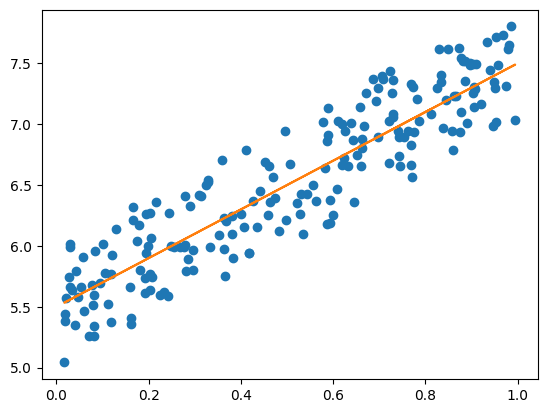

In [24]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.rand(200, 1)
y = 5 + 2 * x + np.random.rand(200, 1)

plt.plot(x, y, 'o')
plt.plot(x, 5+2*x+0.5)

In [25]:
x, y = Variable(x), Variable(y)

W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))

def predict(x):
    return F.matmul(x, W) + b

def mean_squared_error(x0, x1):
    diff = x0 - x1
    return F.sum(diff ** 2) / len(diff)

lr = 0.1
iters = 10

# 경사하강법으로 파라미터 최적화
# 선형 회귀이기 때문에 y = Wx + b를 만족하는 W, b를 찾는 과정
for i in range(iters):
    y_pred = predict(x)
    loss = mean_squared_error(y, y_pred)
    
    W.cleargrad()
    b.cleargrad()
    loss.backward()
    
    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data
    print(W, b, loss)

variable([[0.69968479]]) variable([1.30540317]) variable(43.0464243799336)
variable([[1.21813053]]) variable([2.27862715]) variable(23.912251875131552)
variable([[1.60167799]]) variable([3.0045244]) variable(13.305951530304382)
variable([[1.88482746]]) variable([3.54626799]) variable(7.42651691335438)
variable([[2.09326398]]) variable([3.95089058]) variable(4.16711632874706)
variable([[2.24610963]]) variable([4.25340836]) variable(2.3599694635626984)
variable([[2.35760038]]) variable([4.47989115]) variable(1.3577957435722379)
variable([[2.43833445]]) variable([4.64974824]) variable(0.8018184906768259)
variable([[2.49620182]]) variable([4.77743011]) variable(0.4931736921645675)
variable([[2.53707611]]) variable([4.8736954]) variable(0.3216341344191469)


## mean_squared_error 문제점

+ mse 계산 과정 중간에 연산하면서 불필요한 역전파 메모리를 잡아먹는다.
+ 따라서 함수 자체를 구현하여 제공한다.
+ 이후 나머지 함수나 클래스에 대해서도 같은 방식으로 함수로 구현하여 불필요한 메모리 낭비를 줄인다.

In [26]:
class MeanSquaredError(Function):
    def forward(self, x0, x1):
        diff = x0 - x1
        return (diff ** 2).sum() / len(diff)
    
    def backward(self, gy):
        x0, x1 = self.inputs
        diff = x0 - x1
        gx0 = gy * diff * (2. / len(diff))
        gx1 = -gx0
        return gx0, gx1
    
def mean_squared_error(x0, x1):
    return MeanSquaredError()(x0, x1)

# 신경망

## linear 함수 생성

+ affine 계층은 matmul, sum으로 이루어져 있으며 이를 mse처럼 linear 함수로 생성

In [27]:
def linear_simple(x, W, b=None):
    t = F.matmul(x, W)
    if b is None:
        return t
    
    y = t + b
    
    # fully connected layer층을 함수로 만들었기 때문에 메모리 관리를 위해 t의 data를 None으로 변환
    t.data = None
    return y

In [28]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
W = Variable(np.array([[0], [1], [2]]))
y = linear_simple(x, W)
y.backward()

print(y.data)
print(x.grad)

[[ 8]
 [17]]
variable([[0 1 2]
          [0 1 2]])


In [29]:
def sigmoid_simple(x):
    x = as_variable(x)
    y = 1 / (1 + F.exp(-x))
    return y

In [30]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = sigmoid_simple(x)
y.backward()

print(y.data)
print(x.grad)

[[0.73105858 0.88079708 0.95257413]
 [0.98201379 0.99330715 0.99752738]]
variable([[0.19661193 0.10499359 0.04517666]
          [0.01766271 0.00664806 0.00246651]])


## 비선형 데이터셋에 대하여 신경망 구현

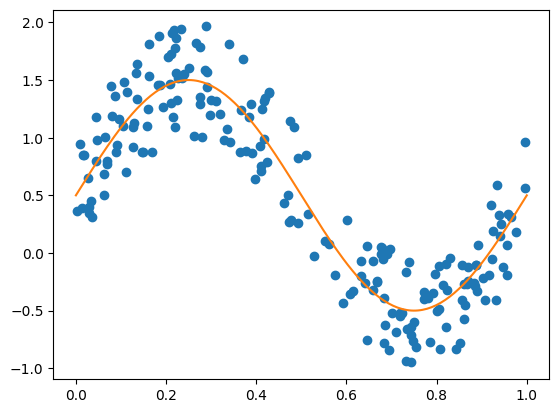

In [31]:
x = np.random.rand(200, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(200, 1)

plt.plot(x, y, 'o')
plt.plot(np.linspace(0, 1, 200), np.sin(np.linspace(0, 2*np.pi, 200))+0.5)

In [32]:
inputs, hidden, outputs = 1, 10, 1

W1 = Variable(0.01 * np.random.randn(inputs, hidden))
b1 = Variable(np.zeros(hidden))
W2 = Variable(0.01 * np.random.randn(hidden, outputs))
b2 = Variable(np.zeros(outputs))

def linear_model(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y

lr = 0.2
iters = 10

for i in range(iters):
    y_pred = linear_model(x)
    loss = F.mean_squared_error(y, y_pred)
    
    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()
    
    W1.data -= lr * W1.grad.data
    b1.data -= lr * b1.grad.data
    W2.data -= lr * W2.grad.data
    b2.data -= lr * b2.grad.data
    print(loss)

variable(0.8762257225875565)
variable(0.6800855844632104)
variable(0.648460811156152)
variable(0.6432131930386646)
variable(0.6422981542185275)
variable(0.6420750343986614)
variable(0.6419627726966424)
variable(0.6418679836191946)
variable(0.6417757465436915)
variable(0.6416836547073433)


# layer 구현

+ 층이 깊어지면서 parameter관리가 어려워짐
+ parameter만 관리하는 class 구현

In [33]:
from dezero.core import Parameter

class Layer:
    # 파라미터를 set으로 관리
    def __init__(self):
        self._params = set()
        
    # 파라미터를 추가하는 메서드
    def __setattr__(self, name, value):
        if isinstance(value, (Parameter, Layer)):
            self._params.add(name)
        super().__setattr__(name, value)

In [34]:
layer = Layer()
layer.p1 = Parameter(np.array(1))
layer.p2 = Parameter(np.array(2))
layer.p3 = Variable(np.array(3))
layer.p4 = 'test'

print(layer._params)

{'p1', 'p2'}


In [35]:
from dezero.core import Parameter
import weakref

class Layer:
    def __init__(self):
        self._params = set()
        
    def __setattr__(self, name, value):
        if isinstance(value, (Parameter, Layer)):
            self._params.add(name)
        super().__setattr__(name, value)
        
    # 약한참조로 파라미터 관리
    def __call__(self, *inputs):
        outputs = self.forward(*inputs)
        if not isinstance(outputs, tuple):
            outputs = (outputs,)
        self.inputs = [weakref.ref(x) for x in inputs]
        self.outputs = [weakref.ref(y) for y in outputs]
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, inputs):
        raise NotImplementedError()
    
    # layer의 파라미터를 순회하면서 yield로 반환
    def params(self):
        for name in self._params:
            yield self.__dict__[name]
            
    # 모든 매개변수 초기화
    def cleargrads(self):
        for param in self.params():
            param.cleargrad()

In [36]:
# Layer 클래스를 상속받아 Linear 클래스를 구현
import dezero.cuda as cuda

class Linear(Layer):
    def __init__(self, out_size, nobias=False, dtype=np.float32, in_size=None):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.dtype = dtype
        
        self.W = Parameter(None, name='W')
        if self.in_size is not None:
            self._init_W()
        
        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(out_size, dtype=dtype), name='b')
            
    def _init_W(self):
        I, O = self.in_size, self.out_size
        W_data = np.random.randn(I, O).astype(self.dtype) * np.sqrt(1 / I)
        self.W.data = W_data
        
    def forward(self, x):
        if self.W.data is None:
            self.in_size = x.shape[1]
            xp = cuda.get_array_module(x)
            self._init_W()
        
        y = F.linear(x, self.W, self.b)
        return y

In [38]:
import dezero.layers as L

x = np.random.randn(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

l1 = L.Linear(10)
l2 = L.Linear(1)

def predict(x):
    y = l1(x)
    y = F.sigmoid(y)
    y = l2(y)
    return y

lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)
    
    # 여기 cleargrads() 수정 예정
    l1.cleargrads()
    l2.cleargrads()
    loss.backward()
    
    # 매개변수 갱신 코드를 좀더 간단하게 구현
    for l in [l1, l2]:
        for p in l.params():
            p.data -= lr * p.grad.data
    
    if i % 1000 == 0:
        print(loss)

variable(1.2617182183943276)
variable(0.5074120063862628)
variable(0.5042938690882776)
variable(0.5033372774383248)
variable(0.500935467960015)
variable(0.4895186875387012)
variable(0.4363790001090843)
variable(0.2379625064587276)
variable(0.16636797456882643)
variable(0.15603133743469497)


# layer 확장

+ layer도 여러개 사용하면서 복잡해짐
+ layer를 처리할 수 있도록 해야함

---

조금씩 복잡해지는중인거 같다. 